In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))

In [81]:
%matplotlib notebook
import matplotlib.pyplot as plt 
import numpy as np
import torch

import nmf.mult
import nmf.pgrad
import nmf.nesterov

import nmf_torch.mult
import nmf_torch.pgrad
import nmf_torch.nesterov
import nmf_torch.norms

import matplotlib
import pickle

from read_data.reading import read_reuters21578, HashTfidfVectoriser

from performance.performance_eval_func import get_random_lowrank_matrix, get_time_ratio,\
                              compare_performance, plot_performance_dict,\
                              torch_algo_wrapper, plot_errors_dict,\
                              plot_ratios_gpu_algo, plot_ratios_cpu_gpu, plot_ratios_cpu_algo,\
                              plot_differences_gpu_algo, plot_differences_cpu_gpu, plot_differences_cpu_algo

In [4]:
vectorizer=HashTfidfVectoriser(12000)
reuters_data = read_reuters21578("data/reuters21578", vectorizer=vectorizer)

data/reuters21578/reut2-000.sgm
data/reuters21578/reut2-001.sgm
data/reuters21578/reut2-002.sgm
data/reuters21578/reut2-003.sgm
data/reuters21578/reut2-004.sgm
data/reuters21578/reut2-005.sgm
data/reuters21578/reut2-006.sgm
data/reuters21578/reut2-007.sgm
data/reuters21578/reut2-008.sgm
data/reuters21578/reut2-009.sgm
data/reuters21578/reut2-010.sgm
data/reuters21578/reut2-011.sgm
data/reuters21578/reut2-012.sgm
data/reuters21578/reut2-013.sgm
data/reuters21578/reut2-014.sgm
data/reuters21578/reut2-015.sgm
data/reuters21578/reut2-016.sgm
data/reuters21578/reut2-017.sgm
data/reuters21578/reut2-018.sgm
data/reuters21578/reut2-019.sgm
data/reuters21578/reut2-020.sgm
data/reuters21578/reut2-021.sgm


In [5]:
algo_dict_to_test = {
    "mult": nmf.mult.factorise_Fnorm,
    "pgrad": nmf.pgrad.factorise_Fnorm_subproblems,
    "nesterov": nmf.nesterov.factorise_Fnorm,

    "mult_torch": torch_algo_wrapper(nmf_torch.mult.factorise_Fnorm, 
                                     device="cuda"),
    "pgrad_torch": torch_algo_wrapper(nmf_torch.pgrad.factorise_Fnorm_subproblems, 
                                      device="cuda"),
    "nesterov_torch": torch_algo_wrapper(nmf_torch.nesterov.factorise_Fnorm, 
                                        device="cuda")
}

In [ ]:
errors_result = errors_at_time_t_over_inner_dim(
                            reuters_data,
                            range(20, 400, 20),
                            200, algo_dict_to_test)

In [ ]:
f, ax = plt.subplots()
ax.set_title("reuters_data")
plot_dict(errors_result, ax, log=False)

# Performance evaluation

In [57]:
errors_dict = pickle.load(open("text_data_errors_dict.pkl","rb"))

In [8]:
inner_dim = 120
shape = reuters_data.shape

In [ ]:
W_init = np.random.rand(shape[0], inner_dim) * 0.001
H_init = np.random.rand(inner_dim, shape[1]) * 0.001

errors_dict = compare_performance(reuters_data.toarray(), 
                                  inner_dim, time_limit=1000,
                                  W_init=W_init, H_init=H_init, 
                                  algo_dict_to_test=algo_dict_to_test)

Starting mult
Starting pgrad
Starting nesterov


In [10]:
pickle.dump(errors_dict,  open("text_data_errors_dict.pkl","wb"))

In [2]:
!ls -l *pkl

-rw-r--r-- 1 root    root        531382 Feb 18 17:42 faces_data_errors_dict.pkl
-rw-r--r-- 1 root    root    1954653367 Feb 17 18:45 random_data_errors_dict.pkl
-rw-r--r-- 1 aiadmin aiadmin   16336643 Feb 14 15:38 random_data_errors_dict_old.pkl
-rw-r--r-- 1 root    root        121363 Feb 18 17:24 text_data_errors_dict.pkl


## Ratios

In [84]:
nmbytes = 1975.52
shape = (21578, 12000)
inner_dim = 120

In [69]:
errors_dict["pgrad_torch"] .shape

(1964, 2)

In [78]:
errors_dict["pgrad_torch"] = errors_dict["pgrad_torch"][:800,:]

<IPython.core.display.Javascript object>


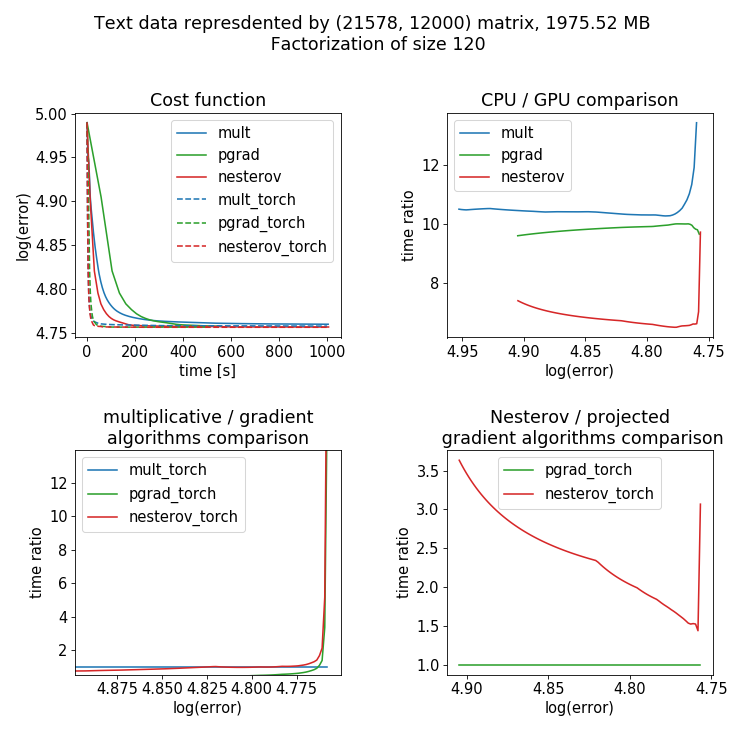

Text(0.5,1,'Nesterov / projected\n gradient algorithms comparison')

In [108]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), 
                       gridspec_kw=gridspec_kw)

# shape = reuters_data.shape
# nbytes = reuters_data.toarray().nbytes


f.suptitle("Text data represdented by {0} matrix, {2:.2f} MB \n Factorization of size {1}".format(shape, inner_dim,
                                                                       nmbytes))


plot_errors_dict(errors_dict, axes[0, 0], log=True, title="Cost function", x_lbl="time [s]")
plot_ratios_cpu_gpu(errors_dict, axes[0, 1])
# plot_ratios_cpu_algo(errors_dict, axes[0, 1:], selected_algs=["mult", "pgrad", "nesterov"])
plot_ratios_gpu_algo(errors_dict, axes[1, 0:], selected_algs=["mult_torch", "pgrad_torch", "nesterov_torch"])

axes[0, 1].set_title("CPU / GPU comparison")
axes[1, 0].set_title("multiplicative / gradient\nalgorithms comparison")
axes[1, 1].set_title("Nesterov / projected\n gradient algorithms comparison")

In [11]:
axes[1:, 0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dbfff97b8>],
      dtype=object)

## Differences

<IPython.core.display.Javascript object>


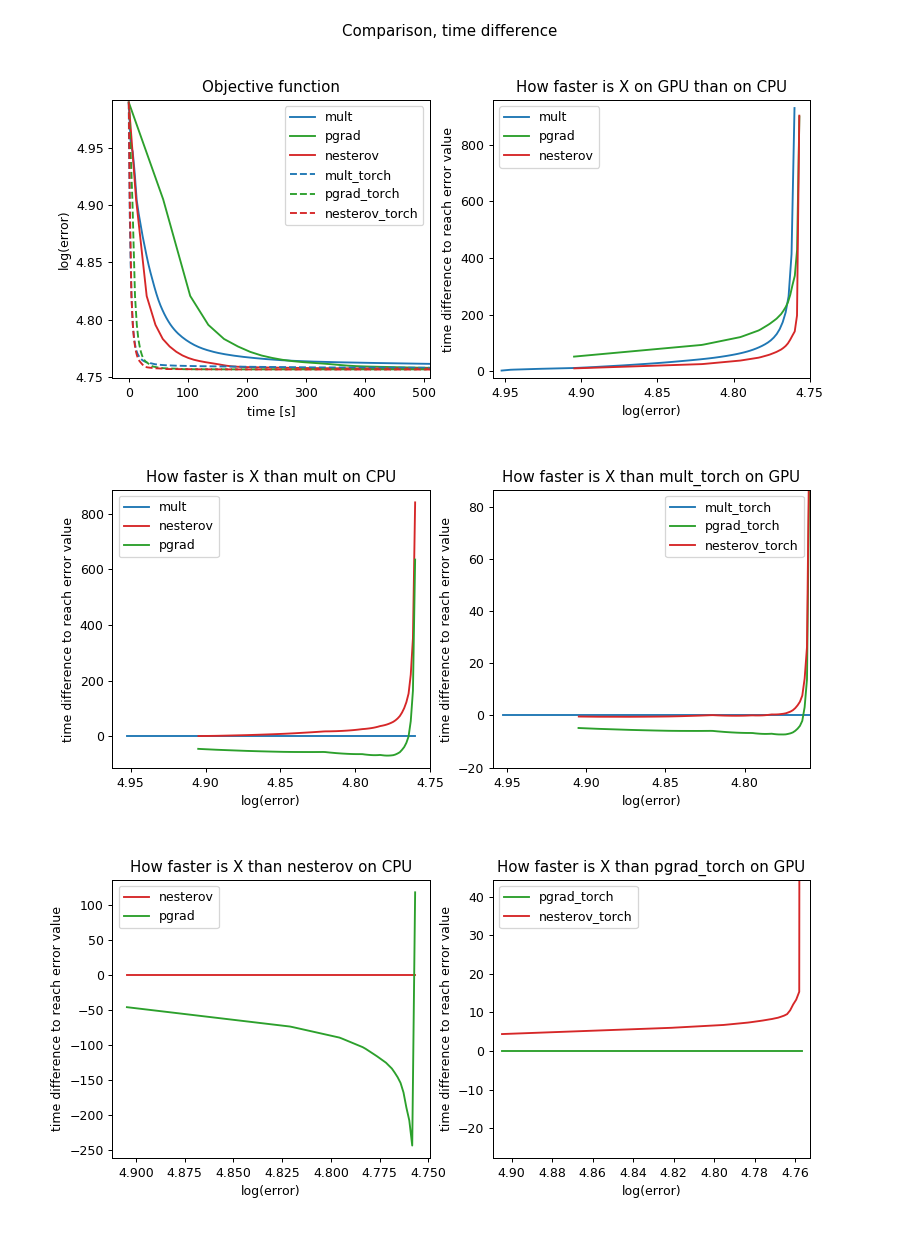

In [13]:
f, axes = plt.subplots(3, 2, figsize=(10, 14), gridspec_kw=dict(hspace=0.4, top=0.92, bottom=0.08))
f.suptitle("Comparison, time difference")

plot_errors_dict(errors_dict, axes[0, 0], log=True, title="Objective function", x_lbl="time [s]")

plot_differences_cpu_gpu(errors_dict, axes[0, 1])
plot_differences_cpu_algo(errors_dict, axes[1:, 0])
plot_differences_gpu_algo(errors_dict, axes[1:, 1])

# Demonstration

In [13]:
W, H, errors = nmf.nesterov.factorise_Fnorm(reuters_data.toarray(), 120, max_steps=20,
                                           epsilon=0, record_errors=True)

<IPython.core.display.Javascript object>


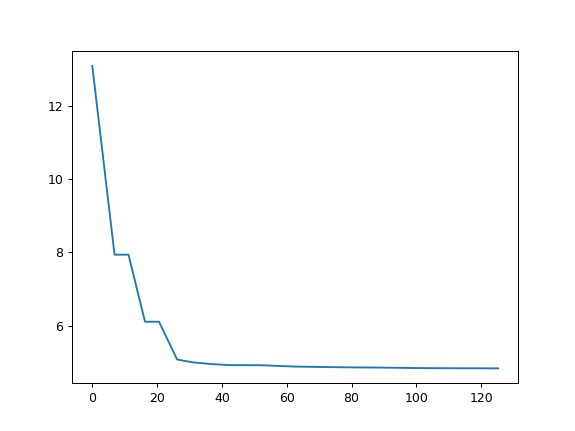

In [14]:
plt.plot(errors[:, 0], np.log(errors[:, 1]))

In [8]:
for topic_id in range(H.shape[0]):
    hashes = cols[topic_id, :3]
    words = ["({})".format("|".join(vectorizer.words_by_hash(h))) for h in hashes]
    print(topic_id, *words)

0 (sacramento|dividend|examines|arlene|favour|documents) (thrufax|faulty|split|dotronix|dalmo) (payable|kdd|files|hindus)
1 (transfering|furr|gle|the) (to|blot) (nge|dilemma|vs|sintered)
2 (transfering|furr|gle|the) (of|moulds) (and|koepfgen|bom)
3 (transfering|furr|gle|the) (nge|dilemma|vs|sintered) (of|moulds)
4 (residues|offering|potently|bancroft|luce) (imm|favorable|prototypes|marred|onemi|inc) (abs|mackes|securities|exeuctive|reallocate|connected|gingerich)
5 (nge|dilemma|vs|sintered) (cts|dishwashers|saudia|ega) (complies|shr|axelrod)
6 (transfering|furr|gle|the) (of|moulds) (to|blot)
7 (transfering|furr|gle|the) (blunt|triguna|said) (preconstruction|geologists|personal|in|brunei|arco)
8 (transfering|furr|gle|the) (of|moulds) (nge|dilemma|vs|sintered)
9 (transfering|furr|gle|the) (of|moulds) (to|blot)
10 (transfering|furr|gle|the) (nge|dilemma|vs|sintered) (of|moulds)
11 (issuers|incineration|sales) (auctioned|year|delorme) (petrovic|rapier|from)
12 (transfering|furr|gle|the) (o

In [29]:
text_id_of_interest = 160
text_vector_of_interest = W[text_id_of_interest, :]

In [30]:
idxs = np.argsort(np.linalg.norm(W[:, :] - text_vector_of_interest, axis=1))

In [31]:
print("text:\n")
print(vectorizer.last_data[idxs[0]])

positions = [1, 2, 19000, 20000]
for i in positions: 
    print("\n{}:".format(i))
    print(vectorizer.last_data[idxs[i]])

text:

Torchmark Corp is raising 200 mln dlrs
through an offering of sinking fund debentures due 2017
yielding 8.65 pct, said lead manager First Boston Corp.
    The debentures have an 8-5/8 pct coupon and were priced at
99.73 to yield 100 basis points over the off-the-run 9-1/4 pct
Treasury bonds of 2016.
    Non-refundable for 10 years, the issue is rated A-2 by
Moody's and AA by Standard and Poor's.
    A sinking fund starts in 1998 to retire 76 pct of the
debentures by maturity, giving them an estimated maximum life
of 22.4 years. Merrill Lynch co-managed the deal.
 Reuter


1:
FPL Group Capital Inc, a unit of FPL
Group Inc, is raising 150 mln dlrs through an offering of
debentures due 2017 yielding 8.951 pct, said lead manager
Salomon Brothers Inc.
    The debentures have an 8-7/8 pct coupon and were priced at
99.20 to yield 135 basis points over the off-the-run 9-1/4 pct
Treasury bonds of 2016.
    Non-refundable for five years, the issue is rated A-2 by
Moody's and A-plus by St

In [1]:
!ls *pkl

faces_data_errors_dict.pkl   random_data_errors_dict_old.pkl
random_data_errors_dict.pkl  text_data_errors_dict.pkl
